# Baseline model

## ARIMA

In [2]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
%load_ext autoreload
%autoreload 2

### Import data

In [4]:
from electricity_price_predictor.data_2 import get_price, get_shifted_price

In [5]:
df= get_shifted_price()
df.head()

,price
time,
2015-01-01 00:00:00,25.02
2015-01-01 01:00:00,18.29
2015-01-01 02:00:00,16.04
2015-01-01 03:00:00,14.60
2015-01-01 04:00:00,14.95


### Decomposition of hourly data

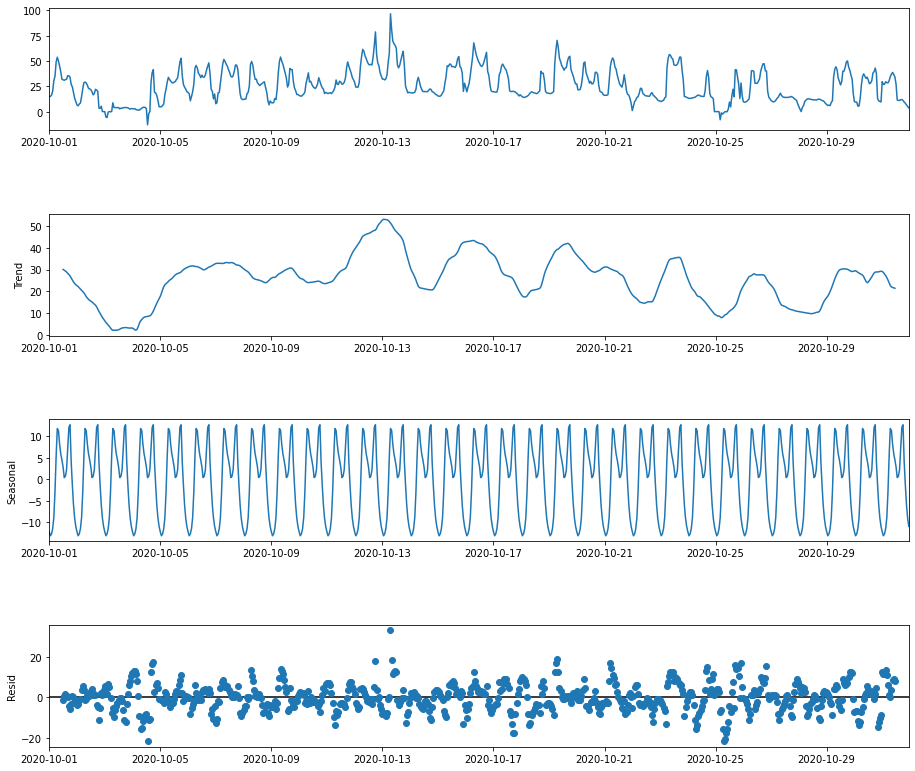

In [19]:
df_2020_10 = df[(df.index.year==2020) & (df.index.month==10)]
decompose_2020_10 = seasonal_decompose(df_2020_10, model='additive')
fig = decompose_2020_10.plot()
fig.set_size_inches(14, 12);

### Decomposition of df_hour_11

In [14]:
# get all the data for 11 am 
df_hour_11 = df[df.index.hour==11]
df_hour_11.head()

,price
time,
2015-01-01 11:00:00,16.08
2015-01-02 11:00:00,15.08
2015-01-03 11:00:00,22.31
2015-01-04 11:00:00,27.32
2015-01-05 11:00:00,40.97


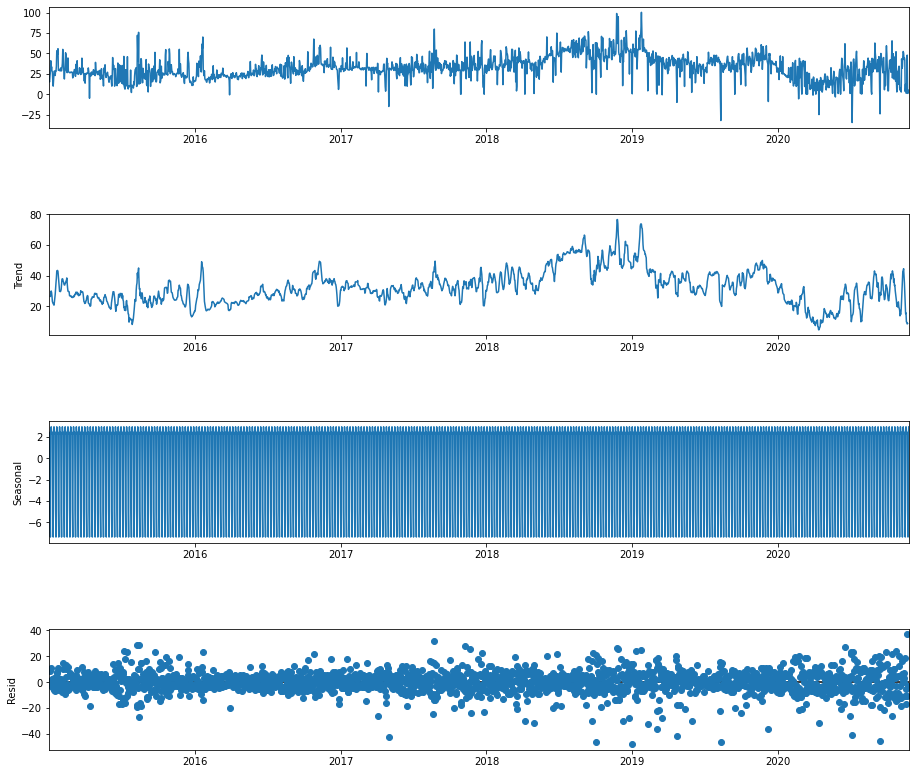

In [16]:
# for 5 years
decompose_5y = seasonal_decompose(df_hour_11, model='additive')
fig = decompose_5y.plot()
fig.set_size_inches(14, 12);

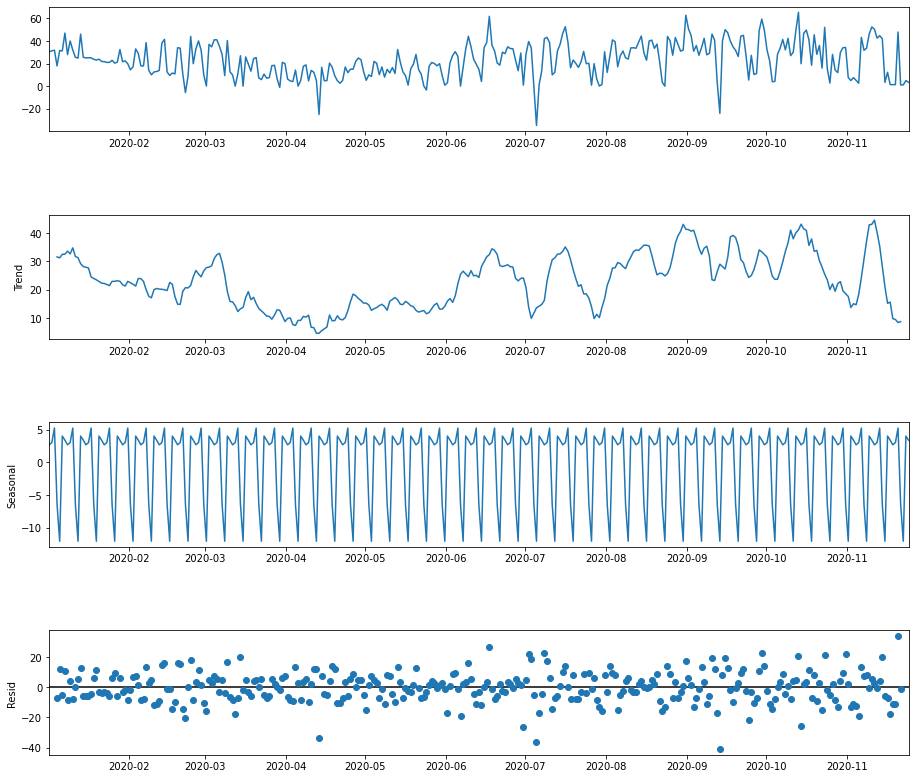

In [18]:
# for year 2020 
decompose_2020 = seasonal_decompose(df_hour_11[(df_hour_11.index.year==2020)], model='additive')
fig = decompose_2020.plot()
fig.set_size_inches(14, 12);

Text(0.5, 1.0, 'First order diff of seasonal differencing 7 days')

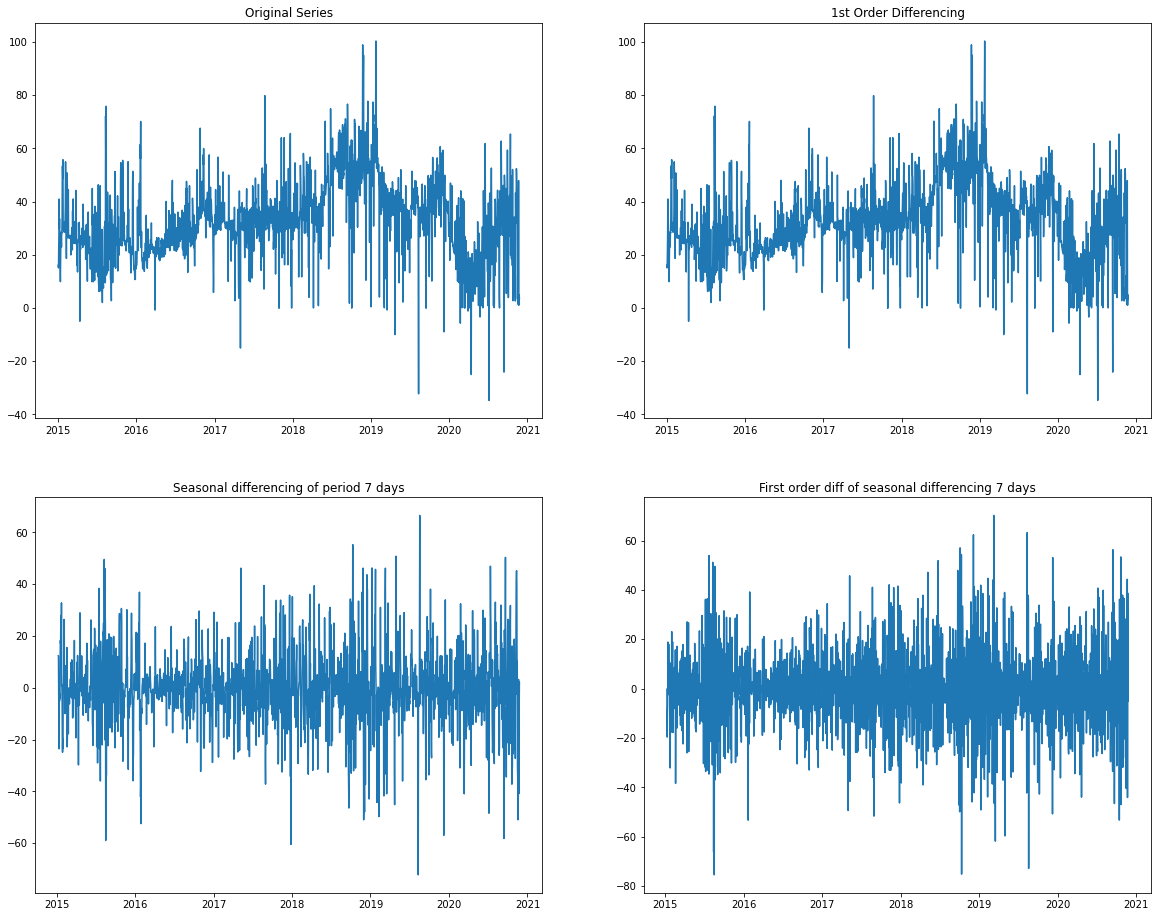

In [25]:
# Explore stationarity

fig, axs = plt.subplots(2, 2, figsize=(20,16))
# Original series
axs[0,0].plot(df_hour_11); axs[0,0].set_title('Original Series')

# Normal differencing
axs[0,1].plot(df_hour_11); axs[0,1].set_title('1st Order Differencing')

# Seasonal differencing
axs[1,0].plot(df_hour_11.diff(7)) # remove weekly seasonality to see stationarity
axs[1,0].set_title('Seasonal differencing of period 7 days')

# Week + Normal differencing
axs[1,1].plot(df_hour_11.diff(7).diff(1))
axs[1,1].set_title('First order diff of seasonal differencing 7 days')

In [23]:
# checkout whether the residuals stationarity
print('additive resid: ', adfuller(decompose_5y.resid.dropna())[1])

additive resid:  2.9215481940148257e-30


**No exponentail trend observed, but there is a clear weekly seasonality**

### Autocorrelation

#### df_hour_11

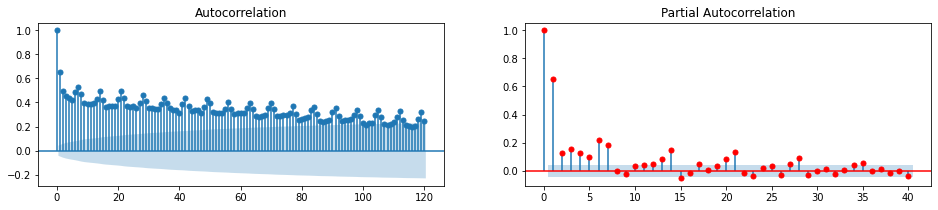

In [26]:
# plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df_hour_11, lags=120, ax=axes[0]);
plot_pacf(df_hour_11, lags=40, ax=axes[1], color='r');

#### After removing weekly seasonality

In [186]:
# remove the weekly seasonality
df_hour_11_deseasonalized = df_hour_11.diff(7).dropna()

In [182]:
df_hour_11_deseasonalized = pd.DataFrame((df_hour_11.price - decompose_5y.seasonal), columns=['price'])

In [183]:
df_hour_11_deseasonalized

,price
time,
2015-01-01 11:00:00,13.820321
2015-01-02 11:00:00,12.650693
2015-01-03 11:00:00,27.204267
2015-01-04 11:00:00,34.705496
2015-01-05 11:00:00,38.784895
...,...
2020-11-20 11:00:00,45.480693
2020-11-21 11:00:00,5.944267
2020-11-22 11:00:00,8.545496


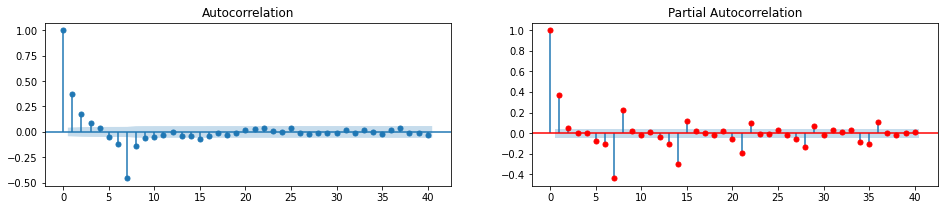

In [187]:
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df_hour_11_deseasonalized, lags=40, ax=axes[0]);
plot_pacf(df_hour_11_deseasonalized, lags=40, ax=axes[1], color='r');

### ARIMA model based on ACF and PACF

In [134]:
from statsmodels.tsa.arima_model import ARIMA
arima = ARIMA(df_hour_11_deseasonalized, order=(1,1,1), freq='D')
arima = arima.fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.price   No. Observations:                 2147
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8538.351
Method:                       css-mle   S.D. of innovations             12.889
Date:                Thu, 26 Nov 2020   AIC                          17084.701
Time:                        17:04:51   BIC                          17107.388
Sample:                    01-09-2015   HQIC                         17093.002
                         - 11-24-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0003      0.001     -0.395      0.693      -0.002       0.001
ar.L1.D.price     0.3717      0.020     18.540      0.000       0.332       0.411
ma.L1.D.price    -1.0000      0.001   -856.263      0.000      -1.002      -0.998
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.6903           +0.0000j            2.6903            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

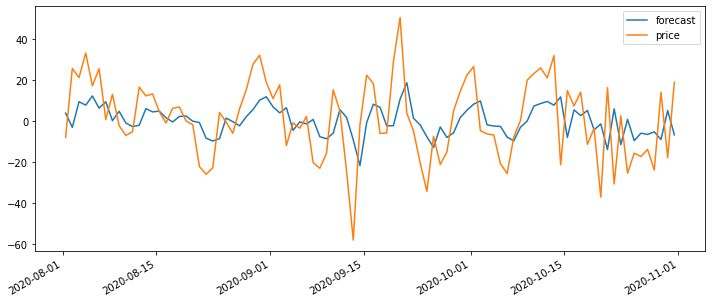

In [156]:
arima.plot_predict('2020-08', '2020-10')
fig = plt.gcf() 
fig.set_size_inches(12, 5);

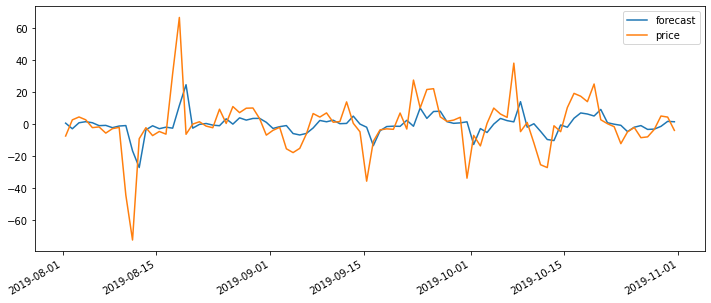

In [155]:
arima.plot_predict('2019-08', '2019-10')
fig = plt.gcf() 
fig.set_size_inches(12, 5);

### Grid search hyperparam

In [185]:
# grid search the hyper params
import pmdarima as pm
smodel = pm.auto_arima(df_hour_11_deseasonalized, seasonal=False, 
                       start_p=0, max_p=2, 
                       start_q=0, max_q=2, 
                       trace=True) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16482.645, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16240.949, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15981.304, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16480.645, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15812.132, Time=0.82 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15813.193, Time=1.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15813.141, Time=1.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15842.135, Time=0.57 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16122.693, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15813.924, Time=2.65 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15810.163, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15979.315, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16238.950, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=15811.224, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0

### Evaluate the model

In [148]:
df_hour_11_deseasonalized.index.dtype

dtype('<M8[ns]')

In [160]:
# Create a correct Training/Test split to predict the last 50 points
train = df_hour_11[df_hour_11.index.year == 2019]
test = df_hour_11[df_hour_11.index.year == 2020]

In [161]:
# Build Model
arima = ARIMA(train, order=(1, 1, 1), freq='D')
arima = arima.fit()

# Forecast
forecast, std_err, confidence_int = arima.forecast(len(test), alpha=0.05)  # 95% confidence

In [162]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None
    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

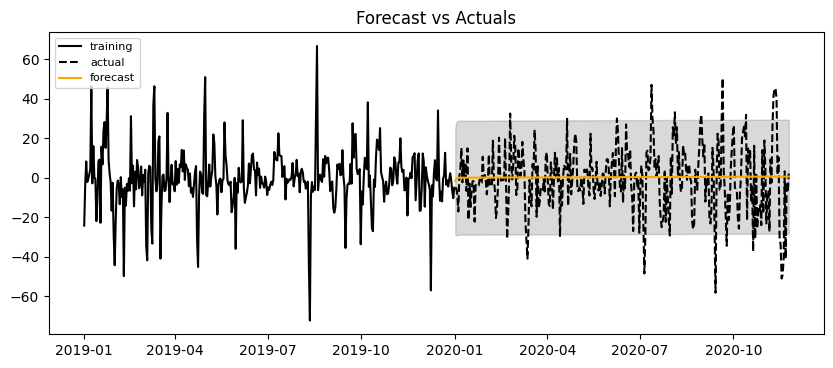

In [163]:
plot_forecast(forecast, train, test, confidence_int[:,0], confidence_int[:,1])

### Re-compose back

## SARIMAX Model

In [ ]:
df_daily_mean.shape

In [ ]:
# Create a correct Training/Test split to predict the last 50 points
train_df = df_daily_mean[:2150]
test_df = df_daily_mean[2150:]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build Model
sarima = SARIMAX(train_df,
                 order=(3, 0, 0),seasonal_order=(0,1,2,12)
                )
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(test_df), alpha=0.05) # 95% confidence
forecast = results.predicted_mean
confidence_int = results.conf_int()

In [ ]:
plot_forecast(forecast, train_df, test_df)

## Inference validity

In [ ]:
## plot residuals to see whether their normal distributed
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build Model
sarima = SARIMAX(engod=df['electricity_price'],
                 exog=df['day_of_week'],
                 order=(3, 0, 0),seasonal_order=(0,1,2,12)
                )
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(test), alpha=0.05) # 95% confidence
forecast = results.predicted_mean
confidence_int = results.conf_int()

# Prophet

[reference for model_b](https://towardsdatascience.com/multivariate-time-series-forecasting-using-random-forest-2372f3ecbad1)